# Amazon Fine Food Reviews Analysis - Logistic Regression


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## [7.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy import stats
from scipy.stats import uniform
from scipy.sparse import csr_matrix
from collections import Counter

from prettytable import PrettyTable

from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score

from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [2]:

# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

('Number of data points in our data', (525814, 10))


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


#  Exploratory Data Analysis

## [7.1.2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [3]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

In [10]:
#Deduplication of entries
#final=sorted_data.drop_duplicates(subset={"Score"}, keep='first', inplace=False)
#final.shape

final_pos_reviews=final.loc[final['Score'] == 1]
final_neg_reviews=final.loc[final['Score']== 0]

In [11]:
final_new=final.sample(n=80000)

final=final.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

labels = final_new['Score']


In [12]:
new_final=final_new.sort_values('Time')
final=new_final
new_labels=final['Score']

## 7.2.3  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [13]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

1
What happens when you say his name three times? Michael Keaten stars in this comedy about two couples that live in an old two story house.  While coming back from a supply store, the couple suddenly get caught inside of a  &quot;broken-up&quot; bridge and then just before they start to tumble down  into the lake, a board catches them.  But just when they've got their hopes  up, and small dog steps on the board and the car starts to slide off the  bridge and into the lake waters.  A few minutes later...<p>They find  themselves back into their home, they find that somehow somehad light the  fireplace, as if done by magic.  From then on, they find a weird-looking  dead guy known as Bettlejuice.  The only way they can get him for help is  to call him by his name three times and he will appear at their survice.  But they soon wish that they have never called his name, because  Bettlejuice was once a troublemaker but he is the only one who can save  them, on the account that they said his 

In [14]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ksumanth01/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

set([u'all', u'just', u"don't", u'being', u'over', u'both', u'through', u'yourselves', u'its', u'before', u'o', u'don', u'hadn', u'herself', u'll', u'had', u'should', u'to', u'only', u'won', u'under', u'ours', u'has', u"should've", u"haven't", u'do', u'them', u'his', u'very', u"you've", u'they', u'not', u'during', u'now', u'him', u'nor', u"wasn't", u'd', u'did', u'didn', u'this', u'she', u'each', u'further', u"won't", u'where', u"mustn't", u"isn't", u'few', u'because', u"you'd", u'doing', u'some', u'hasn', u"hasn't", u'are', u'our', u'ourselves', u'out', u'what', u'for', u"needn't", u'below', u're', u'does', u"shouldn't", u'above', u'between', u'mustn', u't', u'be', u'we', u'who', u"mightn't", u"doesn't", u'were', u'here', u'shouldn', u'hers', u"aren't", u'by', u'on', u'about', u'couldn', u'of', u"wouldn't", u'against', u's', u'isn', u'or', u'own', u'into', u'yourself', u'down', u"hadn't", u'mightn', u"couldn't", u'wasn', u'your', u"you're", u'from', u'her', u'their', u'aren', u"it's",

In [16]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
if not os.path.isfile('final.sqlite'):
    i=0
    str1=' '
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    s=''
    for sent in tqdm(final['Text'].values):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 'positive': 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 'negative':
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                    else:
                        continue
                else:
                    continue 
        #print(filtered_sentence)
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")

        final_string.append(str1)
        i+=1

    #############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    with open('positive_words.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('negitive_words.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)

In [17]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

# Bag of Words - Unigrams

In [26]:
# Dividing raw train and test data
X = final['CleanedText']
y = np.array(new_labels)

X_train = X[:int(0.7*len(X))]
y_train = y[:int(0.7*len(y))]
X_test = X[len(X_train):]
y_test = y[len(y_train):]

In [27]:
# Applying bow on train data
count_vect = CountVectorizer()
train_final = count_vect.fit_transform(X_train)
print(type(train_final))
print("Train data shape: ",train_final.get_shape())

# Standardizing X_train data
# Create the Scaler object
scaler = preprocessing.StandardScaler(with_mean=False)
# Fit your data on the scaler object
standardized_Xtrain = scaler.fit_transform(train_final)

test_final = count_vect.transform(X_test)   # applying bow on test data
print("Test data shape: ",test_final.get_shape())

standardized_Xtest = scaler.transform(test_final)   # Standardizing X_test data

<class 'scipy.sparse.csr.csr_matrix'>
('Train data shape: ', (56000, 28730))
('Test data shape: ', (24000, 28730))


### With L2 Regularizer


GridSearchCV
('Best C : ', 0.0001)
('Training Score : ', 95.01691914767802)
('Training Error : ', 4.983080852321976)
('Test Score : ', 89.2670165031364)
('Test Error : ', 10.732983496863596)
('Confusion matrix : \n', array([[ 3249,   916],
       [ 1753, 18082]]))


Text(0.5,1,'Heatmap for confusion matrix')

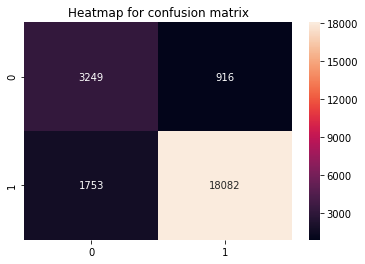

In [20]:
# GridSearchCV to find best C with l2

tuned_C_grid = [{'C': [10**(i) for i in range (-4,4)]}]

model1 = GridSearchCV(LogisticRegression(random_state=5,penalty='l2',class_weight='balanced',n_jobs=-1),tuned_C_grid, cv=3,n_jobs=-1)
model1.fit(standardized_Xtrain, y_train)

print ("\nGridSearchCV")
# Obtaining best C
best_C1 = model1.best_estimator_.get_params()['C']
print ("Best C : ",best_C1)

# Training model with X_train and prediction for X_test
clf1 = LogisticRegression(C=best_C1, penalty='l2',random_state=5,class_weight='balanced',n_jobs=-1)
clf1.fit(standardized_Xtrain,y_train)

pred = clf1.predict(standardized_Xtrain)
training_score = f1_score(y_train,pred,average='weighted') * 100
training_error = 100-training_score
print ("Training Score : ",training_score)
print ("Training Error : ",training_error)

pred = clf1.predict(standardized_Xtest)
test_score = f1_score(y_test,pred,average='weighted') * 100
test_error = 100-test_score
print ("Test Score : ",test_score)
print ("Test Error : ",test_error)

confusion = confusion_matrix(y_test, pred)
print ("Confusion matrix : \n",confusion)
ax = sns.heatmap(confusion, annot=True, fmt="d")
ax.set_title('Heatmap for confusion matrix')

RandomizedSearchCV
('Best C : ', 0.6596374487594618)
('Training Score : ', 98.71235267241238)
('Training Error : ', 1.2876473275876208)
('Test Score : ', 84.96247253318582)
('Test Error : ', 15.037527466814183)
('Confusion matrix : \n', array([[ 2647,  1518],
       [ 2199, 17636]]))


Text(0.5,1,'Heatmap for confusion matrix')

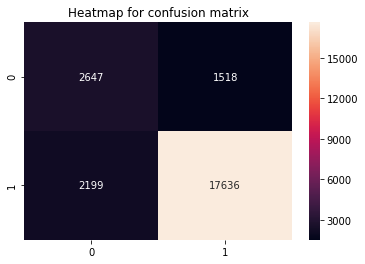

In [21]:
# RandomizedSearchCV to find best C with l2

tuned_C_random = dict(C=uniform(10**-4,10**4))
#Using RandomizedSearchCV
model2 = RandomizedSearchCV(LogisticRegression(penalty='l2',random_state=5,class_weight='balanced',n_jobs=-1), tuned_C_random, cv=3,n_jobs=-1)
model2.fit(standardized_Xtrain, y_train)
print ("RandomizedSearchCV")

best_C2 = model2.best_estimator_.get_params()['C']
print ("Best C : ",best_C2)

clf2 = LogisticRegression(C=best_C2, penalty='l2',random_state=5,class_weight='balanced',n_jobs=-1)
clf2.fit(standardized_Xtrain, y_train)

pred = clf2.predict(standardized_Xtrain)
training_score = f1_score(y_train,pred,average='weighted')*100
training_error = 100-training_score
print ("Training Score : ",training_score)
print ("Training Error : ",training_error)

pred = clf2.predict(standardized_Xtest)
test_score = f1_score(y_test,pred,average='weighted') * 100
test_error = 100-test_score
print ("Test Score : ",test_score)
print ("Test Error : ",test_error)

confusion = confusion_matrix(y_test, pred)
print ("Confusion matrix : \n",confusion)
ax = sns.heatmap(confusion, annot=True, fmt="d")
ax.set_title('Heatmap for confusion matrix')

  0%|          | 0/16 [00:00<?, ?it/s]

('lambda: ', [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 4.0, 9.0, 15.0, 30.0, 60.0, 90.0, 100.0, 300.0, 500.0, 800.0])
('C: ', [10000.0, 1000.0, 100.0, 10.0, 2.0, 1.0, 0.25, 0.11111, 0.06667, 0.03333, 0.01667, 0.01111, 0.01, 0.00333, 0.002, 0.00125])


100%|██████████| 16/16 [11:22<00:00, 14.61s/it]


+--------------+----------+----------+
| Lambda Value |  Error   | Sparsity |
+--------------+----------+----------+
|    0.0001    | 16.93107 |    0     |
|    0.001     | 17.11596 |    0     |
|     0.01     | 17.16116 |    0     |
|     0.1      | 16.22577 |    0     |
|     0.5      | 15.60541 |    0     |
|     1.0      | 15.29059 |    0     |
|     4.0      | 14.41785 |    0     |
|     9.0      | 13.96341 |    0     |
|     15.0     | 13.74944 |    0     |
|     30.0     | 13.29891 |    0     |
|     60.0     | 12.85443 |    0     |
|     90.0     | 12.50065 |    0     |
|    100.0     | 12.42103 |    0     |
|    300.0     | 11.88438 |    0     |
|    500.0     | 11.5807  |    0     |
|    800.0     | 11.37493 |    0     |
+--------------+----------+----------+


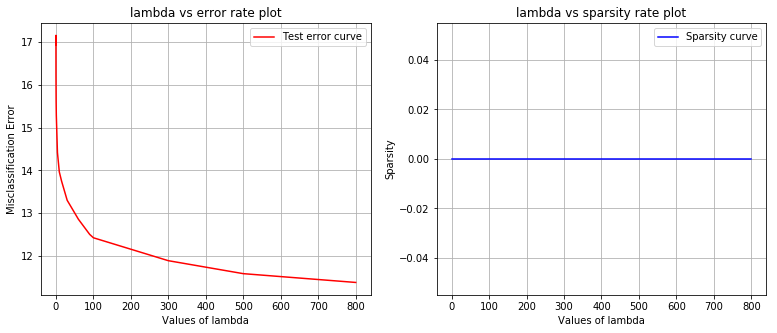

In [22]:
# Error and sparsity check with l2 regularizer

lambda_values = [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 4, 9, 15, 30, 60, 90, 100, 300, 500,800]
lambda_values=[float(i) for i in lambda_values]
print ("lambda: ",lambda_values)

c = [round((1.0/i),5) for i in lambda_values]
print ("C: ",c)

x = PrettyTable()
x.field_names = ["Lambda Value","Error","Sparsity"]
scores = []
sparsity = []
j=0
for i in tqdm(c):
    clf = LogisticRegression(penalty='l2',C=i,random_state=5,n_jobs=-1,class_weight='balanced').fit(standardized_Xtrain, y_train)
    pred = clf.predict(standardized_Xtest)
    sco = f1_score(y_test, pred, average='weighted')*100
    scores.append(100-sco)
    weight_vector = clf.coef_[0]
    zeros=0
    for i in weight_vector:
        if i==0:
            zeros+=1
    sparsity.append(zeros)
    x.add_row([round(lambda_values[j],5),round((100-sco),5),zeros])
    j+=1;

print (x)

plt.figure(figsize=(13, 5))
ax = plt.subplot(121)
ax.set(xlabel='Values of lambda', ylabel='Misclassification Error', title='lambda vs error rate plot')
ax.plot(lambda_values,scores,color="red")
ax.legend(['Test error curve'])
ax.grid(True)

ax = plt.subplot(122)
ax.set(xlabel='Values of lambda', ylabel='Sparsity', title='lambda vs sparsity rate plot')
ax.plot(lambda_values,sparsity,color="blue")
ax.legend(['Sparsity curve'])
ax.grid(True)

plt.show()

From the above plots the rate of misclassification error decreases with the value of increasing lambda and sparsity is 0 throughout all values of lambda.

### With L1 Regularizer


GridSearchCV
('Best C : ', 0.01)
('Training Score : ', 82.7099731241223)
('Training Error : ', 17.2900268758777)
('Test Score : ', 70.27441048868333)
('Test Error : ', 29.72558951131667)
('Confusion matrix : \n', array([[  874,  3269],
       [ 4132, 15725]]))


Text(0.5,1,'Heatmap for confusion matrix')

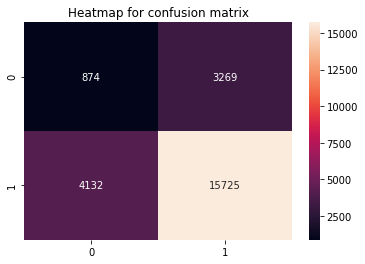

In [28]:
# GridSearchCV to find best C with l1

tuned_C_grid = [{'C': [10**(i) for i in range (-4,4)]}]

model1 = GridSearchCV(LogisticRegression(random_state=5,penalty='l1',class_weight='balanced',n_jobs=-1),tuned_C_grid, cv=3,n_jobs=-1)
model1.fit(standardized_Xtrain, y_train)

print ("\nGridSearchCV")
# Obtaining best C
best_C1 = model1.best_estimator_.get_params()['C']
print ("Best C : ",best_C1)

# Training model with X_train and prediction for X_test
clf1 = LogisticRegression(C=best_C1, penalty='l1',random_state=5,class_weight='balanced',n_jobs=-1)
clf1.fit(standardized_Xtrain,y_train)

pred = clf1.predict(standardized_Xtrain)
training_score = f1_score(y_train,pred,average='weighted') * 100
training_error = 100-training_score
print ("Training Score : ",training_score)
print ("Training Error : ",training_error)

pred = clf1.predict(standardized_Xtest)
test_score = f1_score(y_test,pred,average='weighted') * 100
test_error = 100-test_score
print ("Test Score : ",test_score)
print ("Test Error : ",test_error)

confusion = confusion_matrix(y_test, pred)
print ("Confusion matrix : \n",confusion)
ax = sns.heatmap(confusion, annot=True, fmt="d")
ax.set_title('Heatmap for confusion matrix')

RandomizedSearchCV
('Best C : ', 550.7638848144253)
('Training Score : ', 85.42028024728268)
('Training Error : ', 14.579719752717324)
('Test Score : ', 66.60889119591562)
('Test Error : ', 33.39110880408438)
('Confusion matrix : \n', array([[ 1229,  2914],
       [ 5912, 13945]]))


Text(0.5,1,'Heatmap for confusion matrix')

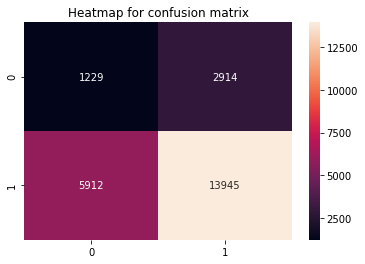

In [29]:
# RandomizedSearchCV to find best C with l1

tuned_C_random = dict(C=uniform(10**-4,10**4))
#Using RandomizedSearchCV
model2 = RandomizedSearchCV(LogisticRegression(random_state=5,penalty='l1',class_weight='balanced',n_jobs=-1),tuned_C_random, cv=3,n_jobs=-1)
model2.fit(standardized_Xtrain, y_train)
print ("RandomizedSearchCV")

best_C2 = model2.best_estimator_.get_params()['C']
print ("Best C : ",best_C2)

clf2 = LogisticRegression(C=best_C2, penalty='l1',random_state=5,class_weight='balanced',n_jobs=-1)
clf2.fit(standardized_Xtrain, y_train)

imp_weight_vector=clf2.coef_[0]

pred = clf2.predict(standardized_Xtrain)
training_score = f1_score(y_train,pred,average='weighted')*100
training_error = 100-training_score
print ("Training Score : ",training_score)
print ("Training Error : ",training_error)

pred = clf2.predict(standardized_Xtest)
test_score = f1_score(y_test,pred,average='weighted') * 100
test_error = 100-test_score
print ("Test Score : ",test_score)
print ("Test Error : ",test_error)

confusion = confusion_matrix(y_test, pred)
print ("Confusion matrix : \n",confusion)
ax = sns.heatmap(confusion, annot=True, fmt="d")
ax.set_title('Heatmap for confusion matrix')

  0%|          | 0/16 [00:00<?, ?it/s]

('lambda: ', [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 4.0, 9.0, 15.0, 30.0, 60.0, 90.0, 100.0, 300.0, 500.0, 800.0])
('C: ', [10000.0, 1000.0, 100.0, 10.0, 2.0, 1.0, 0.25, 0.11111, 0.06667, 0.03333, 0.01667, 0.01111, 0.01, 0.00333, 0.002, 0.00125])


100%|██████████| 16/16 [56:04<00:00, 11.78s/it]   


+--------------+----------+----------+
| Lambda Value |  Error   | Sparsity |
+--------------+----------+----------+
|    0.0001    | 33.35328 |   6680   |
|    0.001     | 33.35127 |   7269   |
|     0.01     | 33.39555 |   8792   |
|     0.1      | 33.48459 |   9185   |
|     0.5      | 33.54957 |   9355   |
|     1.0      | 33.59112 |   9453   |
|     4.0      | 33.6429  |   9953   |
|     9.0      | 33.80307 |  10563   |
|     15.0     | 33.64828 |  11279   |
|     30.0     | 32.99446 |  12912   |
|     60.0     | 31.34035 |  17031   |
|     90.0     | 30.16789 |  21371   |
|    100.0     | 29.72559 |  22201   |
|    300.0     | 27.47735 |  26544   |
|    500.0     | 94.51412 |  28608   |
|    800.0     | 94.91749 |  28730   |
+--------------+----------+----------+


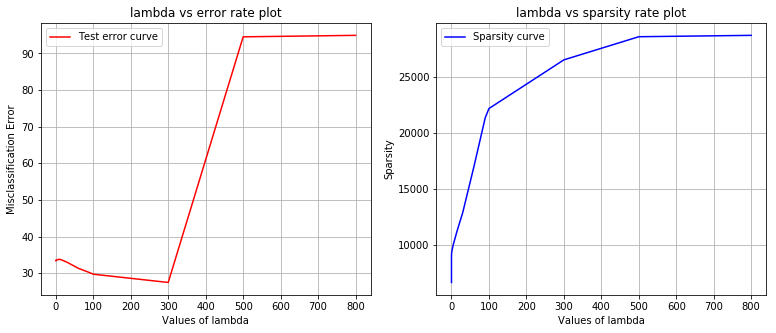

In [30]:
# Error and sparsity check with l1 regularizer

lambda_values = [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 4, 9, 15, 30, 60, 90, 100, 300, 500,800]
lambda_values=[float(i) for i in lambda_values]
print ("lambda: ",lambda_values)

c = [round((1.0/i),5) for i in lambda_values]
print ("C: ",c)

x = PrettyTable()
x.field_names = ["Lambda Value","Error","Sparsity"]
scores = []
sparsity = []
j=0
for i in tqdm(c):
    clf = LogisticRegression(penalty='l1',C=i,random_state=5,n_jobs=-1,class_weight='balanced').fit(standardized_Xtrain, y_train)
    pred = clf.predict(standardized_Xtest)
    sco = f1_score(y_test, pred, average='weighted')*100
    scores.append(100-sco)
    weight_vector = clf.coef_[0]
    zeros=0
    for i in weight_vector:
        if i==0:
            zeros+=1
    sparsity.append(zeros)
    x.add_row([round(lambda_values[j],5),round((100-sco),5),zeros])
    j+=1;

print (x)
      
plt.figure(figsize=(13, 5))
ax = plt.subplot(121)
ax.set(xlabel='Values of lambda', ylabel='Misclassification Error', title='lambda vs error rate plot')
ax.plot(lambda_values,scores,color="red")
ax.legend(['Test error curve'])
ax.grid(True)

ax = plt.subplot(122)
ax.set(xlabel='Values of lambda', ylabel='Sparsity', title='lambda vs sparsity rate plot')
ax.plot(lambda_values,sparsity,color="blue")
ax.legend(['Sparsity curve'])
ax.grid(True)

plt.show()

From the above plots the rate of misclassification error decreases with the value of increasing lambda till 300 and then it drastically picksup till 500 and remains almost constant. The sparsity increases as the lambda value increases and it remained constanct after reaching 500.

### Pertubation test and Feature Importance  

In [31]:
# Adding noise epsilon to each value of train data
epsilon = np.random.normal(0,0.000001)

new_standardized_Xtrain = standardized_Xtrain
new_standardized_Xtrain.data = new_standardized_Xtrain.data+epsilon

In [32]:
clf = LogisticRegression(penalty='l1', C=674.3052869248972,random_state=5,n_jobs=-1,class_weight='balanced')
clf.fit(new_standardized_Xtrain, y_train)

# Obtaining weight vector after adding epsilon noise
noise_weight_vector = clf.coef_[0]

# Obtaining weight vector before adding epsilon noise
weight_vector=imp_weight_vector
count0=0
count30=0
for i in range(0,len(noise_weight_vector)):
    g = abs(max(noise_weight_vector[i],weight_vector[i])- min(noise_weight_vector[i],weight_vector[i]))
    if weight_vector[i]==0.0:
        change=abs(noise_weight_vector[i])
    else:
        change=(abs(weight_vector[i])/g)*100
    if change>0:
        count0+=1
    if change>30:
        count30+=1

# Reporting the changed weight values
print ("After adding noise to weight vector, ",count0," weight values have changed out of ",len(weight_vector),".")
print (count30," weight values have change more than 30% out of ",count0)

('After adding noise to weight vector, ', 21095, ' weight values have changed out of ', 28730, '.')
(20629, ' weight values have change more than 30% out of ', 21095)


In [33]:
words_list=count_vect.get_feature_names()
j=sorted(weight_vector,reverse=True)

pos_indexes=[list(weight_vector).index(i) for i in j[:10]]
pos_words=[words_list[i] for i in pos_indexes]
print("Top 10 positive words/features")
print pos_words

neg_indexes=[list(weight_vector).index(i) for i in j[-10:]]
neg_words=[words_list[i] for i in neg_indexes]
neg_words.reverse()
print("Top 10 negative words/features")
print (neg_words)


Top 10 positive words/features
[u'race', u'cilantro', u'icicl', u'underneath', u'swell', u'moreov', u'flatul', u'latest', u'courier', u'gin']
Top 10 negative words/features
[u'highland', u'soccer', u'pose', u'transplant', u'jds', u'chlorin', u'fart', u'ruptur', u'lesion', u'incandesc']


# TF-IDF Featurization

In [32]:
# Dividing raw train and test data
X = final['CleanedText']
y = np.array(new_labels)

X_train = X[:int(0.7*len(X))]
y_train = y[:int(0.7*len(y))]
X_test = X[len(X_train):]
y_test = y[len(y_train):]

In [33]:
# TF-IDF Vectorizing
# vectorizing X_train
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
train_final_tfidf = tf_idf_vect.fit_transform(X_train)

#vectorizing X_test
test_final_tfidf = tf_idf_vect.transform(X_test) 

# Standardizing X_train data
# Create the Scaler object
scaler = preprocessing.StandardScaler(with_mean=False)
# Fit data on the scaler object
standardized_Xtrain = scaler.fit_transform(train_final_tfidf)

# Standardizing X_test data
standardized_Xtest = scaler.transform(test_final_tfidf)

### With L2 Regularizer


GridSearchCV
('Best C : ', 0.0001)
('Training Score : ', 99.98214719244464)
('Training Error : ', 0.01785280755535723)
('Test Score : ', 75.00472718036508)
('Test Error : ', 24.99527281963492)
('Confusion matrix : \n', array([[   67,  4076],
       [  264, 19593]]))


Text(0.5,1,'Heatmap for confusion matrix')

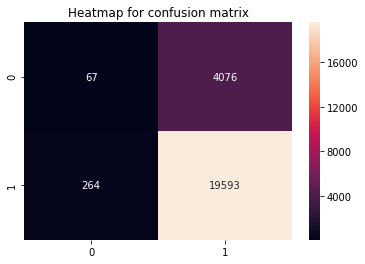

In [36]:
# GridSearchCV to find best C with l2

tuned_C_grid = [{'C': [10**(i) for i in range (-4,4)]}]

model1 = GridSearchCV(LogisticRegression(random_state=5,penalty='l2',n_jobs=-1,class_weight='balanced'),tuned_C_grid, cv=3,n_jobs=-1)
model1.fit(standardized_Xtrain, y_train)

print ("\nGridSearchCV")
# Obtaining best C
best_C1 = model1.best_estimator_.get_params()['C']
print ("Best C : ",best_C1)

# Training model with X_train and prediction for X_test
clf1 = LogisticRegression(C=best_C1, penalty='l2',random_state=5,n_jobs=-1,class_weight='balanced')
clf1.fit(standardized_Xtrain,y_train)

pred = clf1.predict(standardized_Xtrain)
training_score = f1_score(y_train,pred,average='weighted') * 100
training_error = 100-training_score
print ("Training Score : ",training_score)
print ("Training Error : ",training_error)

pred = clf1.predict(standardized_Xtest)
test_score = f1_score(y_test,pred,average='weighted') * 100
test_error = 100-test_score
print ("Test Score : ",test_score)
print ("Test Error : ",test_error)

confusion = confusion_matrix(y_test, pred)
print ("Confusion matrix : \n",confusion)
ax = sns.heatmap(confusion, annot=True, fmt="d")
ax.set_title('Heatmap for confusion matrix')

RandomizedSearchCV
('Best C : ', 7156.413689085606)
('Training Score : ', 99.9875021247705)
('Training Error : ', 0.0124978752294993)
('Test Score : ', 75.05597781037315)
('Test Error : ', 24.94402218962685)
('Confusion matrix : \n', array([[   64,  4079],
       [  228, 19629]]))


Text(0.5,1,'Heatmap for confusion matrix')

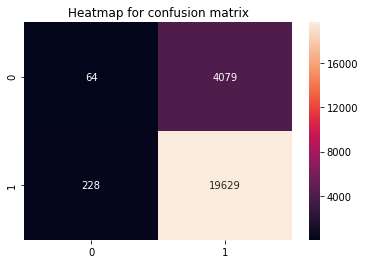

In [37]:
# RandomizedSearchCV to find best C with l2

tuned_C_random = dict(C=uniform(10**-4,10**4))
#Using RandomizedSearchCV
model2 = RandomizedSearchCV(LogisticRegression(penalty='l2',random_state=5,n_jobs=-1,class_weight='balanced'), tuned_C_random, cv=3,n_jobs=-1)
model2.fit(standardized_Xtrain, y_train)
print ("RandomizedSearchCV")

best_C2 = model2.best_estimator_.get_params()['C']
print ("Best C : ",best_C2)

clf2 = LogisticRegression(C=best_C2, penalty='l2',random_state=5,n_jobs=-1,class_weight='balanced')
clf2.fit(standardized_Xtrain, y_train)

pred = clf2.predict(standardized_Xtrain)
training_score = f1_score(y_train,pred,average='weighted')*100
training_error = 100-training_score
print ("Training Score : ",training_score)
print ("Training Error : ",training_error)

pred = clf2.predict(standardized_Xtest)
test_score = f1_score(y_test,pred,average='weighted') * 100
test_error = 100-test_score
print ("Test Score : ",test_score)
print ("Test Error : ",test_error)

confusion = confusion_matrix(y_test, pred)
print ("Confusion matrix : \n",confusion)
ax = sns.heatmap(confusion, annot=True, fmt="d")
ax.set_title('Heatmap for confusion matrix')

  0%|          | 0/16 [00:00<?, ?it/s]

('lambda: ', [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 4.0, 9.0, 15.0, 30.0, 60.0, 90.0, 100.0, 300.0, 500.0, 800.0])
('C: ', [10000.0, 1000.0, 100.0, 10.0, 2.0, 1.0, 0.25, 0.11111, 0.06667, 0.03333, 0.01667, 0.01111, 0.01, 0.00333, 0.002, 0.00125])


100%|██████████| 16/16 [10:26<00:00, 23.47s/it]


+--------------+----------+----------+
| Lambda Value |  Error   | Sparsity |
+--------------+----------+----------+
|    0.0001    | 25.18687 |    0     |
|    0.001     | 25.17804 |    0     |
|     0.01     | 25.20403 |    0     |
|     0.1      | 25.18687 |    0     |
|     0.5      | 25.16701 |    0     |
|     1.0      | 25.17857 |    0     |
|     4.0      | 25.16755 |    0     |
|     9.0      | 25.15873 |    0     |
|     15.0     | 25.19841 |    0     |
|     30.0     | 25.21498 |    0     |
|     60.0     | 25.21218 |    0     |
|     90.0     | 25.21218 |    0     |
|    100.0     | 25.20999 |    0     |
|    300.0     | 25.22316 |    0     |
|    500.0     | 25.23911 |    0     |
|    800.0     | 25.23691 |    0     |
+--------------+----------+----------+


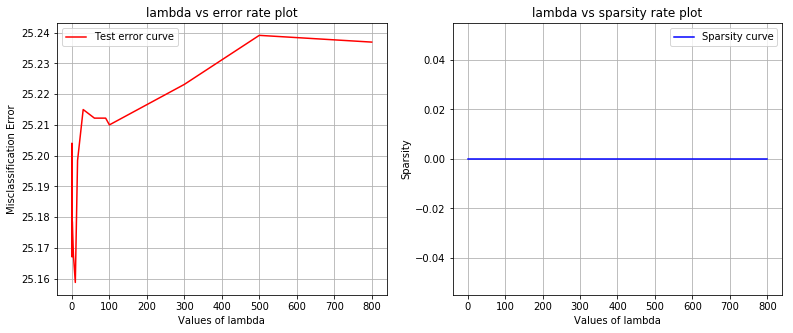

In [34]:
# Error and sparsity check with l2 regularizer

lambda_values = [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 4, 9, 15, 30, 60, 90, 100, 300, 500,800]
lambda_values=[float(i) for i in lambda_values]
print ("lambda: ",lambda_values)

c = [round((1.0/i),5) for i in lambda_values]
print ("C: ",c)

x = PrettyTable()
x.field_names = ["Lambda Value","Error","Sparsity"]
scores = []
sparsity = []
j=0
for i in tqdm(c):
    clf = LogisticRegression(penalty='l2',C=i,random_state=5,n_jobs=-1,class_weight='balanced').fit(standardized_Xtrain, y_train)
    pred = clf.predict(standardized_Xtest)
    sco = f1_score(y_test, pred, average='weighted')*100
    scores.append(100-sco)
    weight_vector = clf.coef_[0]
    zeros=0
    for i in weight_vector:
        if i==0:
            zeros+=1
    sparsity.append(zeros)
    x.add_row([round(lambda_values[j],5),round((100-sco),5),zeros])
    j+=1;

print (x)

plt.figure(figsize=(13, 5))
ax = plt.subplot(121)
ax.set(xlabel='Values of lambda', ylabel='Misclassification Error', title='lambda vs error rate plot')
ax.plot(lambda_values,scores,color="red")
ax.legend(['Test error curve'])
ax.grid(True)

ax = plt.subplot(122)
ax.set(xlabel='Values of lambda', ylabel='Sparsity', title='lambda vs sparsity rate plot')
ax.plot(lambda_values,sparsity,color="blue")
ax.legend(['Sparsity curve'])
ax.grid(True)

plt.show()

Rate of misclassification error is in increasing state as the value of lambda increases. Similarly like for Bow l2 regularization, sparsity is 0 for whatsoever the value of lambda.

### With L1 Regularizer


GridSearchCV
('Best C : ', 10)
('Training Score : ', 99.97679315808263)
('Training Error : ', 0.023206841917371435)
('Test Score : ', 74.7991760394116)
('Test Error : ', 25.200823960588394)
('Confusion matrix : \n', array([[   85,  4097],
       [  329, 19489]]))


Text(0.5,1,'Heatmap for confusion matrix')

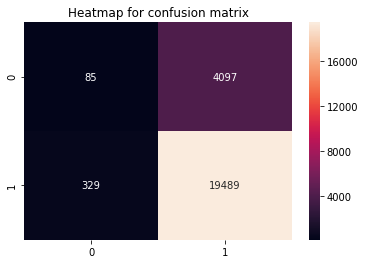

In [35]:
# GridSearchCV to find best C with l1

tuned_C_grid = [{'C': [10**(i) for i in range (-4,4)]}]

model1 = GridSearchCV(LogisticRegression(random_state=5,penalty='l1',n_jobs=-1,class_weight='balanced'),tuned_C_grid, cv=3,n_jobs=-1)
model1.fit(standardized_Xtrain, y_train)

print ("\nGridSearchCV")
# Obtaining best C
best_C1 = model1.best_estimator_.get_params()['C']
print ("Best C : ",best_C1)

# Training model with X_train and prediction for X_test
clf1 = LogisticRegression(C=best_C1, penalty='l1',random_state=5,n_jobs=-1,class_weight='balanced')
clf1.fit(standardized_Xtrain,y_train)

pred = clf1.predict(standardized_Xtrain)
training_score = f1_score(y_train,pred,average='weighted') * 100
training_error = 100-training_score
print ("Training Score : ",training_score)
print ("Training Error : ",training_error)

pred = clf1.predict(standardized_Xtest)
test_score = f1_score(y_test,pred,average='weighted') * 100
test_error = 100-test_score
print ("Test Score : ",test_score)
print ("Test Error : ",test_error)

confusion = confusion_matrix(y_test, pred)
print ("Confusion matrix : \n",confusion)
ax = sns.heatmap(confusion, annot=True, fmt="d")
ax.set_title('Heatmap for confusion matrix')

RandomizedSearchCV
('Best C : ', 170.0817339355904)
('Training Score : ', 99.97679315808263)
('Training Error : ', 0.023206841917371435)
('Test Score : ', 74.73721023002426)
('Test Error : ', 25.26278976997574)
('Confusion matrix : \n', array([[  112,  4070],
       [  464, 19354]]))


Text(0.5,1,'Heatmap for confusion matrix')

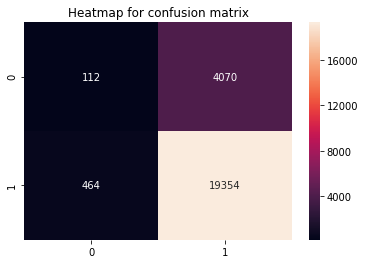

In [36]:
# RandomizedSearchCV to find best C with l1

tuned_C_random = dict(C=uniform(10**-4,10**4))
#Using RandomizedSearchCV
model2 = RandomizedSearchCV(LogisticRegression(penalty='l1',random_state=5,n_jobs=-1,class_weight='balanced'), tuned_C_random, cv=3,n_jobs=-1)
model2.fit(standardized_Xtrain, y_train)
print ("RandomizedSearchCV")

best_C2 = model2.best_estimator_.get_params()['C']
print ("Best C : ",best_C2)

clf2 = LogisticRegression(C=best_C2, penalty='l1',random_state=5,n_jobs=-1,class_weight='balanced')
clf2.fit(standardized_Xtrain, y_train)

imp_weight_vector=clf2.coef_[0]

pred = clf2.predict(standardized_Xtrain)
training_score = f1_score(y_train,pred,average='weighted')*100
training_error = 100-training_score
print ("Training Score : ",training_score)
print ("Training Error : ",training_error)

pred = clf2.predict(standardized_Xtest)
test_score = f1_score(y_test,pred,average='weighted') * 100
test_error = 100-test_score
print ("Test Score : ",test_score)
print ("Test Error : ",test_error)

confusion = confusion_matrix(y_test, pred)
print ("Confusion matrix : \n",confusion)
ax = sns.heatmap(confusion, annot=True, fmt="d")
ax.set_title('Heatmap for confusion matrix')

  0%|          | 0/16 [00:00<?, ?it/s]

('lambda: ', [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 4.0, 9.0, 15.0, 30.0, 60.0, 90.0, 100.0, 300.0, 500.0, 800.0])
('C: ', [10000.0, 1000.0, 100.0, 10.0, 2.0, 1.0, 0.25, 0.11111, 0.06667, 0.03333, 0.01667, 0.01111, 0.01, 0.00333, 0.002, 0.00125])


100%|██████████| 16/16 [10:22<00:00, 81.75s/it] 


+--------------+----------+----------+
| Lambda Value |  Error   | Sparsity |
+--------------+----------+----------+
|    0.0001    | 27.41109 |  103596  |
|    0.001     | 25.61538 |  422646  |
|     0.01     | 25.27889 |  609101  |
|     0.1      | 25.20082 |  725685  |
|     0.5      | 25.76524 |  777228  |
|     1.0      | 25.7563  |  777140  |
|     4.0      | 25.76991 |  782354  |
|     9.0      | 25.78329 |  784223  |
|     15.0     | 25.83368 |  787843  |
|     30.0     | 25.75713 |  789906  |
|     60.0     | 25.90266 |  793694  |
|     90.0     | 26.10264 |  795929  |
|    100.0     | 26.05363 |  796505  |
|    300.0     | 26.61685 |  801742  |
|    500.0     | 26.50913 |  834091  |
|    800.0     | 94.82852 |  836194  |
+--------------+----------+----------+


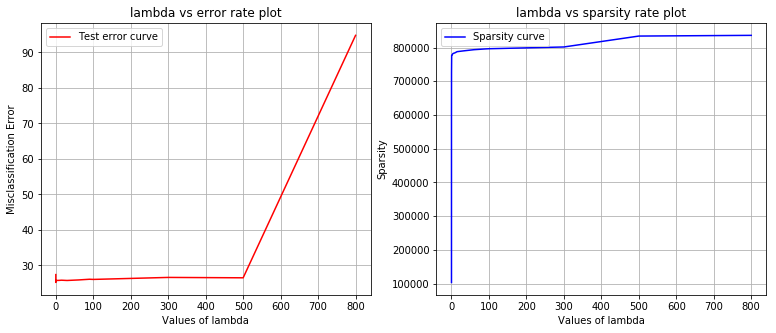

In [37]:
# Error and sparsity check with l1 regularizer

lambda_values = [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 4, 9, 15, 30, 60, 90, 100, 300, 500,800]
lambda_values=[float(i) for i in lambda_values]
print ("lambda: ",lambda_values)

c = [round((1.0/i),5) for i in lambda_values]
print ("C: ",c)

x = PrettyTable()
x.field_names = ["Lambda Value","Error","Sparsity"]
scores = []
sparsity = []
j=0
for i in tqdm(c):
    clf = LogisticRegression(penalty='l1',C=i,random_state=5,n_jobs=-1,class_weight='balanced').fit(standardized_Xtrain, y_train)
    pred = clf.predict(standardized_Xtest)
    sco = f1_score(y_test, pred, average='weighted')*100
    scores.append(100-sco)
    weight_vector = clf.coef_[0]
    zeros=0
    for i in weight_vector:
        if i==0:
            zeros+=1
    sparsity.append(zeros)
    x.add_row([round(lambda_values[j],5),round((100-sco),5),zeros])
    j+=1;

print (x)

plt.figure(figsize=(13, 5))
ax = plt.subplot(121)
ax.set(xlabel='Values of lambda', ylabel='Misclassification Error', title='lambda vs error rate plot')
ax.plot(lambda_values,scores,color="red")
ax.legend(['Test error curve'])
ax.grid(True)

ax = plt.subplot(122)
ax.set(xlabel='Values of lambda', ylabel='Sparsity', title='lambda vs sparsity rate plot')
ax.plot(lambda_values,sparsity,color="blue")
ax.legend(['Sparsity curve'])
ax.grid(True)

plt.show()

Rate of error has a slight increase in the lambda range 0 to 500 and it rises from then. Sparsity kept on increasing for the values near 0 and low rate of increase is observed after reaching 800000 for remaining values of lambda.

### Pertubation test and Feature Importance  

In [38]:
# Adding noise epsilon to each value of train data
epsilon = np.random.normal(0,0.000001)

new_standardized_Xtrain = standardized_Xtrain
new_standardized_Xtrain.data = new_standardized_Xtrain.data+epsilon

In [39]:
clf = LogisticRegression(penalty='l1', C=best_C2,random_state=5,n_jobs=-1,class_weight='balanced')
clf.fit(new_standardized_Xtrain, y_train)

# Obtaining weight vector after adding epsilon noise
noise_weight_vector = clf.coef_[0]

# Obtaining weight vector before adding epsilon noise
weight_vector=imp_weight_vector

count0=0
count30=0
for i in range(0,len(noise_weight_vector)):
    g = abs(max(noise_weight_vector[i],weight_vector[i])- min(noise_weight_vector[i],weight_vector[i]))
    if weight_vector[i]==0.0:
        change=abs(noise_weight_vector[i])
    else:
        change=(abs(weight_vector[i])/g)*100
    if change>0:
        count0+=1
    if change>30:
        count30+=1

# Reporting the changed weight values
print ("After adding noise to weight vector, ",count0," weight values have changed out of ",len(weight_vector),".")
print (count30," weight values have change more than 30% out of ",count0)

('After adding noise to weight vector, ', 244653, ' weight values have changed out of ', 836198, '.')
(244653, ' weight values have change more than 30% out of ', 244653)


In [40]:
words_list=tf_idf_vect.get_feature_names()
j=sorted(weight_vector,reverse=True)

pos_indexes=[list(weight_vector).index(i) for i in j[:10]]
pos_words=[words_list[i] for i in pos_indexes]
print("Top 10 positive words/features")
print pos_words

neg_indexes=[list(weight_vector).index(i) for i in j[-10:]]
neg_words=[words_list[i] for i in neg_indexes]
neg_words.reverse()
print("Top 10 negative words/features")
print (neg_words)


Top 10 positive words/features
[u'product drink', u'excel', u'delici', u'good', u'use', u'worth', u'well apricot', u'packag', u'cant', u'order']
Top 10 negative words/features
[u'tea high', u'high recommend', u'carri product', u'chicken formula', u'love wish', u'product friend', u'lot cheaper', u'delici pleas', u'product glad', u'recommend']


#  Word2Vec Featurization

In [18]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need
is_your_ram_gt_16g=False
want_to_read_sub_set_of_google_w2v = True
want_to_read_whole_google_w2v = True
if not is_your_ram_gt_16g:
    if want_to_read_sub_set_of_google_w2v and  os.path.isfile('google_w2v_for_amazon.pkl'):
        with open('google_w2v_for_amazon.pkl', 'rb') as f:
            # model is dict object, you can directly access any word vector using model[word]
            model = pickle.load(f)
else:
    if want_to_read_whole_google_w2v and os.path.isfile('GoogleNews-vectors-negative300.bin'):
        model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

# print("the vector representation of word 'computer'",model.wv['computer'])
# print("the similarity between the words 'woman' and 'man'",model.wv.similarity('woman', 'man'))
# print("the most similar words to the word 'woman'",model.wv.most_similar('woman'))
# this will raise an error
# model.wv.most_similar('tasti')  # "tasti" is the stemmed word for tasty, tastful

## Average W2V

In [42]:
# Dividing raw train and test data
X = final['CleanedText']
y = np.array(new_labels)

X_train = X[:int(0.7*len(X))]
y_train = y[:int(0.7*len(y))]
X_test = X[len(X_train):]
y_test = y[len(y_train):]

In [43]:
# Training Word2Vec model using own text corpus
list_of_sent1=[]
for sent in X_train:
    list_of_sent1.append(sent.split())

# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent1,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

('number of words that occured minimum 5 times ', 9811)
('sample words ', [u'woodi', u'yellow', u'interchang', u'four', u'decaffin', u'solofil', u'lori', u'lord', u'digit', u'chlorophyl', u'bruschetta', u'deli', u'furikak', u'foul', u'delv', u'disturb', u'prize', u'broiler', u'wooden', u'showcas', u'wednesday', u'superfood', u'unpronounc', u'cheeto', u'bbqs', u'tumer', u'cartilag', u'bacon', u'millet', u'second', u'fece', u'sooth', u'moctail', u'thunder', u'succumb', u'cull', u'eruc', u'avers', u'hero', u'avert', u'wheatgrass', u'splinter', u'accus', u'here', u'china', u'dorm', u'herr', u'doro', u'deterior', u'militari'])


In [44]:
# Vectorizing and standardizing X_train 
# compute average word2vec for each review.
train_sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent1): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_sent_vectors.append(sent_vec)
train_sent_vectors=csr_matrix(train_sent_vectors)

# Standardizing X_train data
scaler = preprocessing.StandardScaler(with_mean=False)
standardized_Xtrain = scaler.fit_transform(train_sent_vectors)

100%|██████████| 56000/56000 [10:10<00:00, 91.80it/s] 


In [45]:
# vectorzing and standardizing X_test
i=0
list_of_sent1=[]
for sent in X_test:
    list_of_sent1.append(sent.split())
    
    
# average Word2Vec
# compute average word2vec for each review.
test_sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent1): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_sent_vectors.append(sent_vec)
test_sent_vectors=csr_matrix(test_sent_vectors)


# Standardizing X_test data
standardized_Xtest = scaler.transform(test_sent_vectors)

100%|██████████| 24000/24000 [04:36<00:00, 86.79it/s] 


### With L2 Regularizer


GridSearchCV
('Best C : ', 10)
('Training Score : ', 58.47053842644533)
('Training Error : ', 41.52946157355467)
('Test Score : ', 55.940454061521436)
('Test Error : ', 44.059545938478564)
('Confusion matrix : \n', array([[2066, 2116],
       [9885, 9933]]))


Text(0.5,1,'Heatmap for confusion matrix')

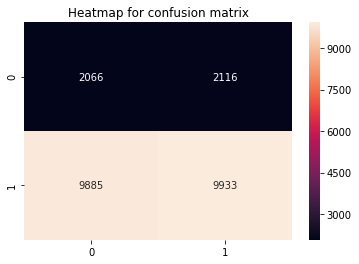

In [46]:
# Applying GridSearchCV with L2 Regularizer

tuned_C_grid = [{'C': [10**(i) for i in range (-4,4)]}]

model1 = GridSearchCV(LogisticRegression(penalty='l2',random_state=5,n_jobs=-1,class_weight='balanced'), tuned_C_grid, cv=3,n_jobs=-1)
model1.fit(standardized_Xtrain, y_train)

print ("\nGridSearchCV")

best_C1 = model1.best_estimator_.get_params()['C']
print ("Best C : ",best_C1)

# Training model with X_train and prediction for X_test
clf1 = LogisticRegression(C=best_C1, penalty='l2',random_state=5,n_jobs=-1,class_weight='balanced')
clf1.fit(standardized_Xtrain,y_train)

pred = clf1.predict(standardized_Xtrain)
training_score = f1_score(y_train,pred,average='weighted') * 100
training_error = 100-training_score
print ("Training Score : ",training_score)
print ("Training Error : ",training_error)

pred = clf1.predict(standardized_Xtest)
test_score = f1_score(y_test,pred,average='weighted') * 100
test_error = 100-test_score
print ("Test Score : ",test_score)
print ("Test Error : ",test_error)

confusion = confusion_matrix(y_test, pred)
print ("Confusion matrix : \n",confusion)
ax = sns.heatmap(confusion, annot=True, fmt="d")
ax.set_title('Heatmap for confusion matrix')

RandomizedSearchCV
('Best C : ', 719.3582951486094)
('Training Score : ', 58.47489962791275)
('Training Error : ', 41.52510037208725)
('Test Score : ', 55.967012805687034)
('Test Error : ', 44.032987194312966)
('Confusion matrix : \n', array([[2067, 2115],
       [9879, 9939]]))


Text(0.5,1,'Heatmap for confusion matrix')

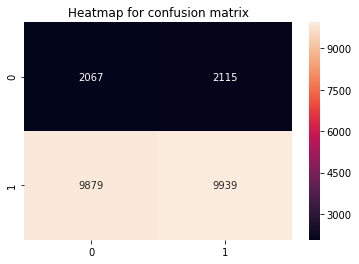

In [47]:
# RandomizedSearchCV to find best C with l2

tuned_C_random = dict(C=uniform(10**-4,10**4))
#Using RandomizedSearchCV
model2 = RandomizedSearchCV(LogisticRegression(penalty='l2',random_state=5,n_jobs=-1,class_weight='balanced'), tuned_C_random, cv=3,n_jobs=-1)
model2.fit(standardized_Xtrain, y_train)
print ("RandomizedSearchCV")

best_C2 = model2.best_estimator_.get_params()['C']
print ("Best C : ",best_C2)

clf2 = LogisticRegression(C=best_C2, penalty='l2',random_state=5,n_jobs=-1,class_weight='balanced')
clf2.fit(standardized_Xtrain, y_train)

pred = clf2.predict(standardized_Xtrain)
training_score = f1_score(y_train,pred,average='weighted')*100
training_error = 100-training_score
print ("Training Score : ",training_score)
print ("Training Error : ",training_error)

pred = clf2.predict(standardized_Xtest)
test_score = f1_score(y_test,pred,average='weighted') * 100
test_error = 100-test_score
print ("Test Score : ",test_score)
print ("Test Error : ",test_error)

confusion = confusion_matrix(y_test, pred)
print ("Confusion matrix : \n",confusion)
ax = sns.heatmap(confusion, annot=True, fmt="d")
ax.set_title('Heatmap for confusion matrix')


  0%|          | 0/16 [00:00<?, ?it/s]

('lambda: ', [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 4.0, 9.0, 15.0, 30.0, 60.0, 90.0, 100.0, 300.0, 500.0, 800.0])
('C: ', [10000.0, 1000.0, 100.0, 10.0, 2.0, 1.0, 0.25, 0.11111, 0.06667, 0.03333, 0.01667, 0.01111, 0.01, 0.00333, 0.002, 0.00125])


100%|██████████| 16/16 [00:54<00:00,  2.57s/it]


+--------------+----------+----------+
| Lambda Value |  Error   | Sparsity |
+--------------+----------+----------+
|    0.0001    | 44.03299 |    0     |
|    0.001     | 44.03299 |    0     |
|     0.01     | 44.03299 |    0     |
|     0.1      | 44.05955 |    0     |
|     0.5      | 44.08995 |    0     |
|     1.0      | 44.12841 |    0     |
|     4.0      | 44.08682 |    0     |
|     9.0      | 44.24616 |    0     |
|     15.0     | 44.39192 |    0     |
|     30.0     | 44.66633 |    0     |
|     60.0     | 44.88043 |    0     |
|     90.0     | 44.98457 |    0     |
|    100.0     | 45.01284 |    0     |
|    300.0     | 45.05255 |    0     |
|    500.0     | 45.06808 |    0     |
|    800.0     | 45.10976 |    0     |
+--------------+----------+----------+


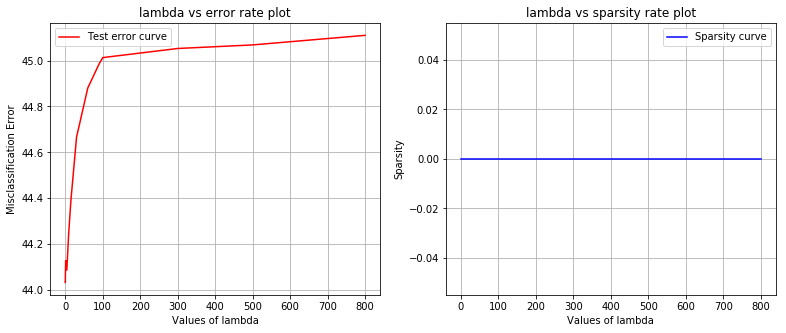

In [48]:
# Error and sparsity check with l2 regularizer

lambda_values = [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 4, 9, 15, 30, 60, 90, 100, 300, 500,800]
lambda_values=[float(i) for i in lambda_values]
print ("lambda: ",lambda_values)

c = [round((1.0/i),5) for i in lambda_values]
print ("C: ",c)

x = PrettyTable()
x.field_names = ["Lambda Value","Error","Sparsity"]
scores = []
sparsity = []
j=0
for i in tqdm(c):
    clf = LogisticRegression(penalty='l2',C=i,random_state=5,n_jobs=-1,class_weight='balanced').fit(standardized_Xtrain, y_train)
    pred = clf.predict(standardized_Xtest)
    sco = f1_score(y_test, pred, average='weighted')*100
    scores.append(100-sco)
    weight_vector = clf.coef_[0]
    zeros=0
    for i in weight_vector:
        if i==0:
            zeros+=1
    sparsity.append(zeros)
    x.add_row([round(lambda_values[j],5),round((100-sco),5),zeros])
    j+=1;

print (x)

plt.figure(figsize=(13, 5))
ax = plt.subplot(121)
ax.set(xlabel='Values of lambda', ylabel='Misclassification Error', title='lambda vs error rate plot')
ax.plot(lambda_values,scores,color="red")
ax.legend(['Test error curve'])
ax.grid(True)

ax = plt.subplot(122)
ax.set(xlabel='Values of lambda', ylabel='Sparsity', title='lambda vs sparsity rate plot')
ax.plot(lambda_values,sparsity,color="blue")
ax.legend(['Sparsity curve'])
ax.grid(True)

plt.show()

The error kept increasing with increase in lambda. High rate is observed between lambda 0 and 100. Sparsity remained constant for all values of lambda.

### With L1 Regularizer


GridSearchCV
('Best C : ', 10)
('Training Score : ', 58.473287483841354)
('Training Error : ', 41.526712516158646)
('Test Score : ', 55.9173883150332)
('Test Error : ', 44.0826116849668)
('Confusion matrix : \n', array([[2066, 2116],
       [9891, 9927]]))


Text(0.5,1,'Heatmap for confusion matrix')

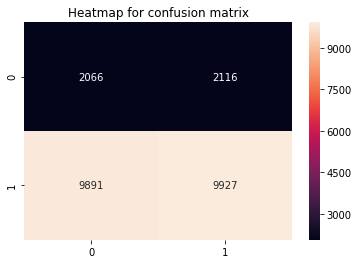

In [49]:
# GridSearchCV to find best C with l1

tuned_C_grid = [{'C': [10**(i) for i in range (-4,4)]}]

model1 = GridSearchCV(LogisticRegression(random_state=5,penalty='l1',n_jobs=-1,class_weight='balanced'),tuned_C_grid, cv=3,n_jobs=-1)
model1.fit(standardized_Xtrain, y_train)

print ("\nGridSearchCV")
# Obtaining best C
best_C1 = model1.best_estimator_.get_params()['C']
print ("Best C : ",best_C1)

# Training model with X_train and prediction for X_test
clf1 = LogisticRegression(C=best_C1, penalty='l1',random_state=5,n_jobs=-1,class_weight='balanced')
clf1.fit(standardized_Xtrain,y_train)

pred = clf1.predict(standardized_Xtrain)
training_score = f1_score(y_train,pred,average='weighted') * 100
training_error = 100-training_score
print ("Training Score : ",training_score)
print ("Training Error : ",training_error)

pred = clf1.predict(standardized_Xtest)
test_score = f1_score(y_test,pred,average='weighted') * 100
test_error = 100-test_score
print ("Test Score : ",test_score)
print ("Test Error : ",test_error)

confusion = confusion_matrix(y_test, pred)
print ("Confusion matrix : \n",confusion)
ax = sns.heatmap(confusion, annot=True, fmt="d")
ax.set_title('Heatmap for confusion matrix')

RandomizedSearchCV
('Best C : ', 1434.253320397136)
('Training Score : ', 58.476511738010515)
('Training Error : ', 41.523488261989485)
('Test Score : ', 55.96735547363409)
('Test Error : ', 44.03264452636591)
('Confusion matrix : \n', array([[2066, 2116],
       [9878, 9940]]))


Text(0.5,1,'Heatmap for confusion matrix')

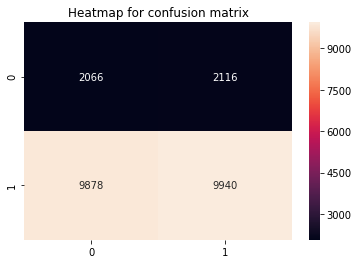

In [50]:
# RandomizedSearchCV to find best C with l1

tuned_C_random = dict(C=uniform(10**-4,10**4))
#Using RandomizedSearchCV
model2 = RandomizedSearchCV(LogisticRegression(penalty='l1',random_state=5,n_jobs=-1,class_weight='balanced'), tuned_C_random, cv=3,n_jobs=-1)
model2.fit(standardized_Xtrain, y_train)
print ("RandomizedSearchCV")

best_C2 = model2.best_estimator_.get_params()['C']
print ("Best C : ",best_C2)

clf2 = LogisticRegression(C=best_C2, penalty='l1',random_state=5,n_jobs=-1,class_weight='balanced')
clf2.fit(standardized_Xtrain, y_train)

pred = clf2.predict(standardized_Xtrain)
training_score = f1_score(y_train,pred,average='weighted')*100
training_error = 100-training_score
print ("Training Score : ",training_score)
print ("Training Error : ",training_error)

pred = clf2.predict(standardized_Xtest)
test_score = f1_score(y_test,pred,average='weighted') * 100
test_error = 100-test_score
print ("Test Score : ",test_score)
print ("Test Error : ",test_error)

confusion = confusion_matrix(y_test, pred)
print ("Confusion matrix : \n",confusion)
ax = sns.heatmap(confusion, annot=True, fmt="d")
ax.set_title('Heatmap for confusion matrix')

  0%|          | 0/16 [00:00<?, ?it/s]

('lambda: ', [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 4.0, 9.0, 15.0, 30.0, 60.0, 90.0, 100.0, 300.0, 500.0, 800.0])
('C: ', [10000.0, 1000.0, 100.0, 10.0, 2.0, 1.0, 0.25, 0.11111, 0.06667, 0.03333, 0.01667, 0.01111, 0.01, 0.00333, 0.002, 0.00125])


100%|██████████| 16/16 [06:07<00:00,  2.41s/it]


+--------------+----------+----------+
| Lambda Value |  Error   | Sparsity |
+--------------+----------+----------+
|    0.0001    | 44.03649 |    0     |
|    0.001     | 44.03264 |    0     |
|     0.01     | 44.05186 |    0     |
|     0.1      | 44.08261 |    0     |
|     0.5      | 44.05639 |    0     |
|     1.0      | 44.11063 |    2     |
|     4.0      | 44.65248 |    3     |
|     9.0      | 44.90261 |    3     |
|     15.0     | 45.1029  |    8     |
|     30.0     | 45.39032 |    15    |
|     60.0     | 45.41785 |    22    |
|     90.0     | 45.34381 |    25    |
|    100.0     | 45.19978 |    27    |
|    300.0     | 42.99864 |    45    |
|    500.0     | 94.82852 |    50    |
|    800.0     | 94.82852 |    50    |
+--------------+----------+----------+


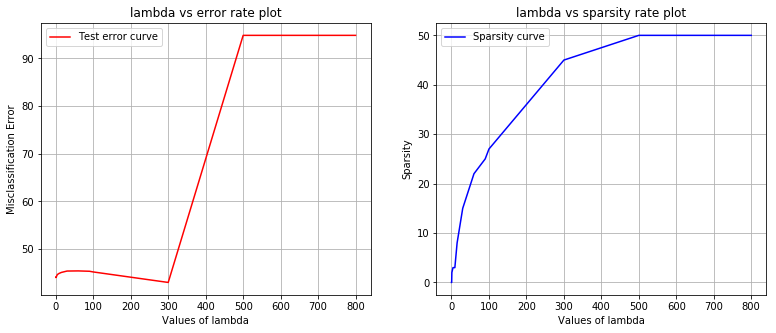

In [51]:
# Error and sparsity check with l1 regularizer

lambda_values = [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 4, 9, 15, 30, 60, 90, 100, 300, 500,800]
lambda_values=[float(i) for i in lambda_values]
print ("lambda: ",lambda_values)

c = [round((1.0/i),5) for i in lambda_values]
print( "C: ",c)

x = PrettyTable()
x.field_names = ["Lambda Value","Error","Sparsity"]
scores = []
sparsity = []
j=0
for i in tqdm(c):
    clf = LogisticRegression(penalty='l1',C=i,random_state=5,n_jobs=-1,class_weight='balanced').fit(standardized_Xtrain, y_train)
    pred = clf.predict(standardized_Xtest)
    sco = f1_score(y_test, pred, average='weighted')*100
    scores.append(100-sco)
    weight_vector = clf.coef_[0]
    zeros=0
    for i in weight_vector:
        if i==0:
            zeros+=1
    sparsity.append(zeros)
    x.add_row([round(lambda_values[j],5),round((100-sco),5),zeros])
    j+=1;

print (x)

plt.figure(figsize=(13, 5))
ax = plt.subplot(121)
ax.set(xlabel='Values of lambda', ylabel='Misclassification Error', title='lambda vs error rate plot')
ax.plot(lambda_values,scores,color="red")
ax.legend(['Test error curve'])
ax.grid(True)

ax = plt.subplot(122)
ax.set(xlabel='Values of lambda', ylabel='Sparsity', title='lambda vs sparsity rate plot')
ax.plot(lambda_values,sparsity,color="blue")
ax.legend(['Sparsity curve'])
ax.grid(True)

plt.show()

Error curve had a slight downfall till lambda 300 and then a drasic increase till 500. There after error remained constant. Sparsity kept on increasing for increasing value of lambada.

# TF-IDF weighted W2V

In [19]:
# Dividing raw train and test data
X = final['CleanedText']
y = np.array(new_labels)

X_train = X[:int(0.7*len(X))]
y_train = y[:int(0.7*len(y))]
X_test = X[len(X_train):]
y_test = y[len(y_train):]

In [23]:
# Vectorizing and Standardizing X_train

list_of_sent1=[]
for sent in X_train:
    list_of_sent1.append(sent.split())
    
w2v_model=Word2Vec(list_of_sent1,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
    
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

train_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent1): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    train_tfidf_sent_vectors.append(sent_vec)
    row += 1
    
train_sent_vectors=csr_matrix(train_tfidf_sent_vectors)

# Standardizing X_train data
scaler = preprocessing.StandardScaler(with_mean=False)
standardized_Xtrain = scaler.fit_transform(train_sent_vectors)

100%|██████████| 56000/56000 [12:29<00:00, 74.74it/s] 


In [24]:
# Vectorizing and Standardizing X_test
list_of_sent=[]
for sent in X_test:
    list_of_sent.append(sent.split())
    

tf_idf_matrix = model.transform(X_test)

test_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    test_tfidf_sent_vectors.append(sent_vec)
    row += 1
    
test_sent_vectors=csr_matrix(test_tfidf_sent_vectors)

# Standardizing X_test data
standardized_Xtest = scaler.transform(test_sent_vectors)

100%|██████████| 24000/24000 [05:32<00:00, 72.23it/s] 


### With L2 Regularizer


GridSearchCV
('Best C : ', 100)
('Training Score : ', 58.694578128061416)
('Training Error : ', 41.305421871938584)
('Test Score : ', 55.3439641383181)
('Test Error : ', 44.6560358616819)
('Confusion matrix : \n', array([[ 2115,  1992],
       [10187,  9706]]))


Text(0.5,1,'Heatmap for confusion matrix')

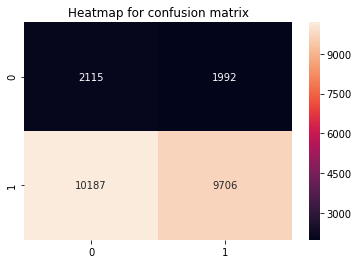

In [25]:
# Applying GridSearchCV with L2 Regularizer

tuned_C_grid = [{'C': [10**(i) for i in range (-4,4)]}]

model1 = GridSearchCV(LogisticRegression(penalty='l2',random_state=5,n_jobs=-1,class_weight='balanced'), tuned_C_grid, cv=3,n_jobs=-1)
model1.fit(standardized_Xtrain, y_train)

print ("\nGridSearchCV")

best_C1 = model1.best_estimator_.get_params()['C']
print ("Best C : ",best_C1)

# Training model with X_train and prediction for X_test
clf1 = LogisticRegression(C=best_C1, penalty='l2',random_state=5,n_jobs=-1,class_weight='balanced')
clf1.fit(standardized_Xtrain,y_train)

pred = clf1.predict(standardized_Xtrain)
training_score = f1_score(y_train,pred,average='weighted') * 100
training_error = 100-training_score
print ("Training Score : ",training_score)
print ("Training Error : ",training_error)

pred = clf1.predict(standardized_Xtest)
test_score = f1_score(y_test,pred,average='weighted') * 100
test_error = 100-test_score
print ("Test Score : ",test_score)
print ("Test Error : ",test_error)

confusion = confusion_matrix(y_test, pred)
print ("Confusion matrix : \n",confusion)
ax = sns.heatmap(confusion, annot=True, fmt="d")
ax.set_title('Heatmap for confusion matrix')

RandomizedSearchCV
('Best C : ', 1554.4365736372729)
('Training Score : ', 58.694578128061416)
('Training Error : ', 41.305421871938584)
('Test Score : ', 55.3439641383181)
('Test Error : ', 44.6560358616819)
('Confusion matrix : \n', array([[ 2115,  1992],
       [10187,  9706]]))


Text(0.5,1,'Heatmap for confusion matrix')

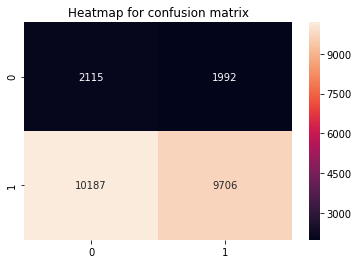

In [26]:
# RandomizedSearchCV to find best C with l2

tuned_C_random = dict(C=uniform(10**-4,10**4))
#Using RandomizedSearchCV
model2 = RandomizedSearchCV(LogisticRegression(penalty='l2',random_state=5,n_jobs=-1,class_weight='balanced'), tuned_C_random, cv=3,n_jobs=-1)
model2.fit(standardized_Xtrain, y_train)
print ("RandomizedSearchCV")

best_C2 = model2.best_estimator_.get_params()['C']
print ("Best C : ",best_C2)

clf2 = LogisticRegression(C=best_C2, penalty='l2',random_state=5,n_jobs=-1,class_weight='balanced')
clf2.fit(standardized_Xtrain, y_train)

pred = clf2.predict(standardized_Xtrain)
training_score = f1_score(y_train,pred,average='weighted')*100
training_error = 100-training_score
print ("Training Score : ",training_score)
print ("Training Error : ",training_error)

pred = clf2.predict(standardized_Xtest)
test_score = f1_score(y_test,pred,average='weighted') * 100
test_error = 100-test_score
print ("Test Score : ",test_score)
print ("Test Error : ",test_error)

confusion = confusion_matrix(y_test, pred)
print ("Confusion matrix : \n",confusion)
ax = sns.heatmap(confusion, annot=True, fmt="d")
ax.set_title('Heatmap for confusion matrix')


  0%|          | 0/16 [00:00<?, ?it/s]

('lambda: ', [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 4.0, 9.0, 15.0, 30.0, 60.0, 90.0, 100.0, 300.0, 500.0, 800.0])
('C: ', [10000.0, 1000.0, 100.0, 10.0, 2.0, 1.0, 0.25, 0.11111, 0.06667, 0.03333, 0.01667, 0.01111, 0.01, 0.00333, 0.002, 0.00125])


100%|██████████| 16/16 [00:25<00:00,  1.42s/it]


+--------------+----------+----------+
| Lambda Value |  Error   | Sparsity |
+--------------+----------+----------+
|    0.0001    | 44.65604 |    0     |
|    0.001     | 44.65604 |    0     |
|     0.01     | 44.65604 |    0     |
|     0.1      | 44.65604 |    0     |
|     0.5      | 44.64823 |    0     |
|     1.0      | 44.65261 |    0     |
|     4.0      | 44.74734 |    0     |
|     9.0      | 44.76787 |    0     |
|     15.0     | 44.79676 |    0     |
|     30.0     | 44.84187 |    0     |
|     60.0     | 44.9975  |    0     |
|     90.0     |  45.094  |    0     |
|    100.0     | 45.10508 |    0     |
|    300.0     | 45.37847 |    0     |
|    500.0     | 45.45788 |    0     |
|    800.0     | 45.59527 |    0     |
+--------------+----------+----------+


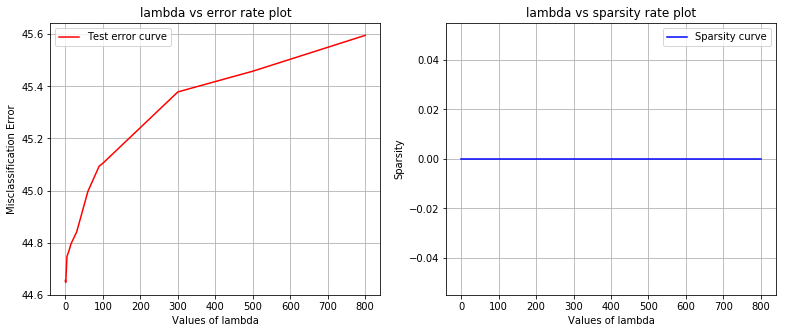

In [27]:
# Error and sparsity check with l2 regularizer

lambda_values = [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 4, 9, 15, 30, 60, 90, 100, 300, 500,800]
lambda_values=[float(i) for i in lambda_values]
print ("lambda: ",lambda_values)

c = [round((1.0/i),5) for i in lambda_values]
print ("C: ",c)

x = PrettyTable()
x.field_names = ["Lambda Value","Error","Sparsity"]
scores = []
sparsity = []
j=0
for i in tqdm(c):
    clf = LogisticRegression(penalty='l2',C=i,random_state=5,n_jobs=-1,class_weight='balanced').fit(standardized_Xtrain, y_train)
    pred = clf.predict(standardized_Xtest)
    sco = f1_score(y_test, pred, average='weighted')*100
    scores.append(100-sco)
    weight_vector = clf.coef_[0]
    zeros=0
    for i in weight_vector:
        if i==0:
            zeros+=1
    sparsity.append(zeros)
    x.add_row([round(lambda_values[j],5),round((100-sco),5),zeros])
    j+=1;

print (x)

plt.figure(figsize=(13, 5))
ax = plt.subplot(121)
ax.set(xlabel='Values of lambda', ylabel='Misclassification Error', title='lambda vs error rate plot')
ax.plot(lambda_values,scores,color="red")
ax.legend(['Test error curve'])
ax.grid(True)

ax = plt.subplot(122)
ax.set(xlabel='Values of lambda', ylabel='Sparsity', title='lambda vs sparsity rate plot')
ax.plot(lambda_values,sparsity,color="blue")
ax.legend(['Sparsity curve'])
ax.grid(True)

plt.show()

Error kept on increasing with increasing values of lambda and sparsity remained constant through out all values of lambda.

### With L1 Regularizer


GridSearchCV
('Best C : ', 100)
('Training Score : ', 58.694578128061416)
('Training Error : ', 41.305421871938584)
('Test Score : ', 55.34786816512559)
('Test Error : ', 44.65213183487441)
('Confusion matrix : \n', array([[ 2115,  1992],
       [10186,  9707]]))


Text(0.5,1,'Heatmap for confusion matrix')

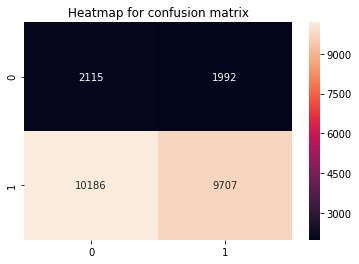

In [28]:
# GridSearchCV to find best C with l1

tuned_C_grid = [{'C': [10**(i) for i in range (-4,4)]}]

model1 = GridSearchCV(LogisticRegression(random_state=5,penalty='l1',n_jobs=-1,class_weight='balanced'),tuned_C_grid, cv=3,n_jobs=-1)
model1.fit(standardized_Xtrain, y_train)

print ("\nGridSearchCV")
# Obtaining best C
best_C1 = model1.best_estimator_.get_params()['C']
print ("Best C : ",best_C1)

# Training model with X_train and prediction for X_test
clf1 = LogisticRegression(C=best_C1, penalty='l1',random_state=5,n_jobs=-1,class_weight='balanced')
clf1.fit(standardized_Xtrain,y_train)

pred = clf1.predict(standardized_Xtrain)
training_score = f1_score(y_train,pred,average='weighted') * 100
training_error = 100-training_score
print ("Training Score : ",training_score)
print ("Training Error : ",training_error)

pred = clf1.predict(standardized_Xtest)
test_score = f1_score(y_test,pred,average='weighted') * 100
test_error = 100-test_score
print ("Test Score : ",test_score)
print ("Test Error : ",test_error)

confusion = confusion_matrix(y_test, pred)
print ("Confusion matrix : \n",confusion)
ax = sns.heatmap(confusion, annot=True, fmt="d")
ax.set_title('Heatmap for confusion matrix')

RandomizedSearchCV
('Best C : ', 2587.6962432558767)
('Training Score : ', 58.694578128061416)
('Training Error : ', 41.305421871938584)
('Test Score : ', 55.34786816512559)
('Test Error : ', 44.65213183487441)
('Confusion matrix : \n', array([[ 2115,  1992],
       [10186,  9707]]))


Text(0.5,1,'Heatmap for confusion matrix')

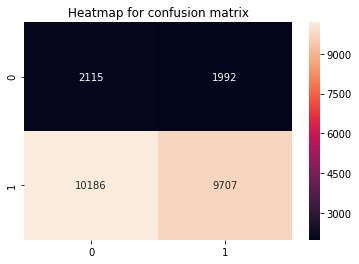

In [29]:
# RandomizedSearchCV to find best C with l1

tuned_C_random = dict(C=uniform(10**-4,10**4))
#Using RandomizedSearchCV
model2 = RandomizedSearchCV(LogisticRegression(penalty='l1',random_state=5,n_jobs=-1,class_weight='balanced'), tuned_C_random, cv=3,n_jobs=-1)
model2.fit(standardized_Xtrain, y_train)
print ("RandomizedSearchCV")

best_C2 = model2.best_estimator_.get_params()['C']
print ("Best C : ",best_C2)

clf2 = LogisticRegression(C=best_C2, penalty='l1',random_state=5,n_jobs=-1,class_weight='balanced')
clf2.fit(standardized_Xtrain, y_train)

pred = clf2.predict(standardized_Xtrain)
training_score = f1_score(y_train,pred,average='weighted')*100
training_error = 100-training_score
print ("Training Score : ",training_score)
print ("Training Error : ",training_error)

pred = clf2.predict(standardized_Xtest)
test_score = f1_score(y_test,pred,average='weighted') * 100
test_error = 100-test_score
print ("Test Score : ",test_score)
print ("Test Error : ",test_error)

confusion = confusion_matrix(y_test, pred)
print ("Confusion matrix : \n",confusion)
ax = sns.heatmap(confusion, annot=True, fmt="d")
ax.set_title('Heatmap for confusion matrix')

('lambda: ', [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 4.0, 9.0, 15.0, 30.0, 60.0, 90.0, 100.0, 300.0, 500.0, 800.0])
('C: ', [10000.0, 1000.0, 100.0, 10.0, 2.0, 1.0, 0.25, 0.11111, 0.06667, 0.03333, 0.01667, 0.01111, 0.01, 0.00333, 0.002, 0.00125])


100%|██████████| 16/16 [02:14<00:00,  1.06s/it]


+--------------+----------+----------+
| Lambda Value |  Error   | Sparsity |
+--------------+----------+----------+
|    0.0001    | 44.65213 |    0     |
|    0.001     | 44.65213 |    0     |
|     0.01     | 44.65213 |    0     |
|     0.1      | 44.66089 |    1     |
|     0.5      | 44.76102 |    0     |
|     1.0      | 44.83202 |    0     |
|     4.0      | 45.13087 |    2     |
|     9.0      | 45.49714 |    5     |
|     15.0     | 45.71962 |    9     |
|     30.0     | 46.24286 |    14    |
|     60.0     | 47.48041 |    23    |
|     90.0     | 48.08522 |    29    |
|    100.0     | 48.32954 |    31    |
|    300.0     | 56.26311 |    44    |
|    500.0     | 55.50736 |    48    |
|    800.0     | 94.99904 |    50    |
+--------------+----------+----------+


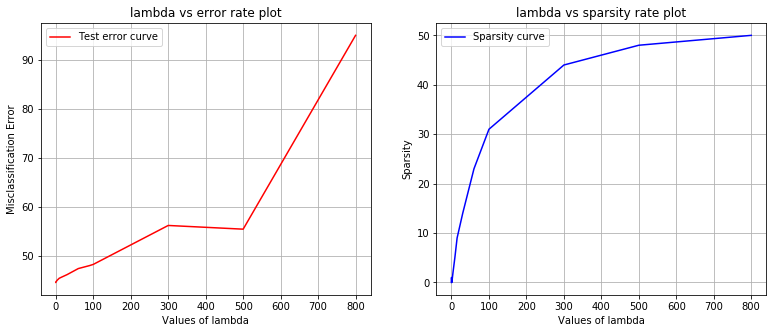

In [30]:
# Error and sparsity check with l1 regularizer

lambda_values = [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 4, 9, 15, 30, 60, 90, 100, 300, 500,800]
lambda_values=[float(i) for i in lambda_values]
print ("lambda: ",lambda_values)

c = [round((1.0/i),5) for i in lambda_values]
print ("C: ",c)

x = PrettyTable()
x.field_names = ["Lambda Value","Error","Sparsity"]
scores = []
sparsity = []
j=0
for i in tqdm(c):
    clf = LogisticRegression(penalty='l1',C=i,random_state=5,n_jobs=-1,class_weight='balanced').fit(standardized_Xtrain, y_train)
    pred = clf.predict(standardized_Xtest)
    sco = f1_score(y_test, pred, average='weighted')*100
    scores.append(100-sco)
    weight_vector = clf.coef_[0]
    zeros=0
    for i in weight_vector:
        if i==0:
            zeros+=1
    sparsity.append(zeros)
    x.add_row([round(lambda_values[j],5),round((100-sco),5),zeros])
    j+=1;

print (x)

plt.figure(figsize=(13, 5))
ax = plt.subplot(121)
ax.set(xlabel='Values of lambda', ylabel='Misclassification Error', title='lambda vs error rate plot')
ax.plot(lambda_values,scores,color="red")
ax.legend(['Test error curve'])
ax.grid(True)

ax = plt.subplot(122)
ax.set(xlabel='Values of lambda', ylabel='Sparsity', title='lambda vs sparsity rate plot')
ax.plot(lambda_values,sparsity,color="blue")
ax.legend(['Sparsity curve'])
ax.grid(True)

plt.show()

Error kept on increasing till lambda 300 and again it started to increase after reaching value 500. Sparsity kept on increasing for increasing value of lambda.

In [3]:
t = PrettyTable()
t.field_names = ["Featurization","Search method","Regularizer","Best lambda","Train Error","Test Error"]
t.add_row(["Bag of Words","GridSearchCV","l2",0.0001,round(4.983080852321976,4),round(10.732983496863596,4)])
t.add_row(["Bag of Words","RandomizedSearchCV","l2",0.6596374487594618,round(1.2876473275876208,4),round(15.037527466814183,4)])
t.add_row(["Bag of Words","GridSearchCV","l1",0.01,round(17.2900268758777,4),round( 29.72558951131667,4)])
t.add_row(["Bag of Words","RandomizedSearchCV","l1",550.7638848144253,round(14.579719752717324,4),round(33.39110880408438,4)])

t.add_row(["TF-IDF","GridSearchCV","l2", 0.0001,round(0.01785280755535723,4),round(24.99527281963492,4)])
t.add_row(["TF-IDF","RandomizedSearchCV","l2",7156.413689085606,round(0.0124978752294993,4),round(24.94402218962685,4)])
t.add_row(["TF-IDF","GridSearchCV","l1", 10,round(0.023206841917371435,4),round(25.200823960588394,4)])
t.add_row(["TF-IDF","RandomizedSearchCV","l1",170.0817339355904,round(0.023206841917371435,4),round(25.26278976997574,4)])

t.add_row(["Avg w2v","GridSearchCV","l2",10,round(41.52946157355467,4),round( 44.059545938478564,4)])
t.add_row(["Avg w2v","RandomizedSearchCV","l2",719.3582951486094,round(41.52510037208725,4),round(44.032987194312966,4)])
t.add_row(["Avg w2v","GridSearchCV","l1", 10,round(41.526712516158646,4),round(44.0826116849668,4)])
t.add_row(["Avg w2v","RandomizedSearchCV","l1",1434.253320397136,round(41.523488261989485,4),round(44.03264452636591,4)])

t.add_row(["TF-IDF weighted w2v","GridSearchCV","l2",100,round(41.305421871938584,4),round(44.6560358616819,4)])
t.add_row(["TF-IDF weighted w2v","RandomizedSearchCV","l2",1554.4365736372729,round(41.305421871938584,4),round(44.6560358616819,4)])
t.add_row(["TF-IDF weighted w2v","GridSearchCV","l1", 100,round(41.305421871938584,4),round(44.65213183487441,4)])
t.add_row(["TF-IDF weighted w2v","RandomizedSearchCV","l1", 2587.6962432558767,round(41.305421871938584,4),round(44.65213183487441,4)])


In [4]:
print(t)

+---------------------+--------------------+-------------+----------------+-------------+------------+
|    Featurization    |   Search method    | Regularizer |  Best lambda   | Train Error | Test Error |
+---------------------+--------------------+-------------+----------------+-------------+------------+
|     Bag of Words    |    GridSearchCV    |      l2     |     0.0001     |    4.9831   |   10.733   |
|     Bag of Words    | RandomizedSearchCV |      l2     | 0.659637448759 |    1.2876   |  15.0375   |
|     Bag of Words    |    GridSearchCV    |      l1     |      0.01      |    17.29    |  29.7256   |
|     Bag of Words    | RandomizedSearchCV |      l1     | 550.763884814  |   14.5797   |  33.3911   |
|        TF-IDF       |    GridSearchCV    |      l2     |     0.0001     |    0.0179   |  24.9953   |
|        TF-IDF       | RandomizedSearchCV |      l2     | 7156.41368909  |    0.0125   |   24.944   |
|        TF-IDF       |    GridSearchCV    |      l1     |       10      

From the above table the lowest value of test error is obtained for BoW with l2 regularization with lambda value 0.0001. Test error is 10.733. The lower values of test error are found for BoW and Tf-idf compared to Avg Tf-idf and Tf-idf weighted w2v. The best hyper parametre lambda is found with both GridSearchCV and RandomizedSearchCV.
